In [1]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import numpy as np
import sklearn

from sklearn.model_selection import train_test_split

## Load Train and Test Datasets

In [2]:
# Load training data
df_train = pd.read_csv('../../0_Datasets/Farm-Flow/train.csv')

In [3]:
# Load testing data
df_test = pd.read_csv('../../0_Datasets/Farm-Flow/test.csv')

In [4]:
X_train = df_train.drop(['is_attack'], axis=1)  # Features
y_train = df_train['is_attack']  # Target variable

In [5]:
X_test = df_test.drop(['is_attack'], axis=1)  # Features
y_test = df_test['is_attack']  # Target variable

## Load Model

In [6]:
from tensorflow.keras.models import load_model

model = load_model('../../2_Modeling_Phase/Saved_Models/Farm-Flow_DNN.keras')

---

## Feature Importance

In [7]:
feature_names = df_train.columns
feature_names = feature_names[:-1]

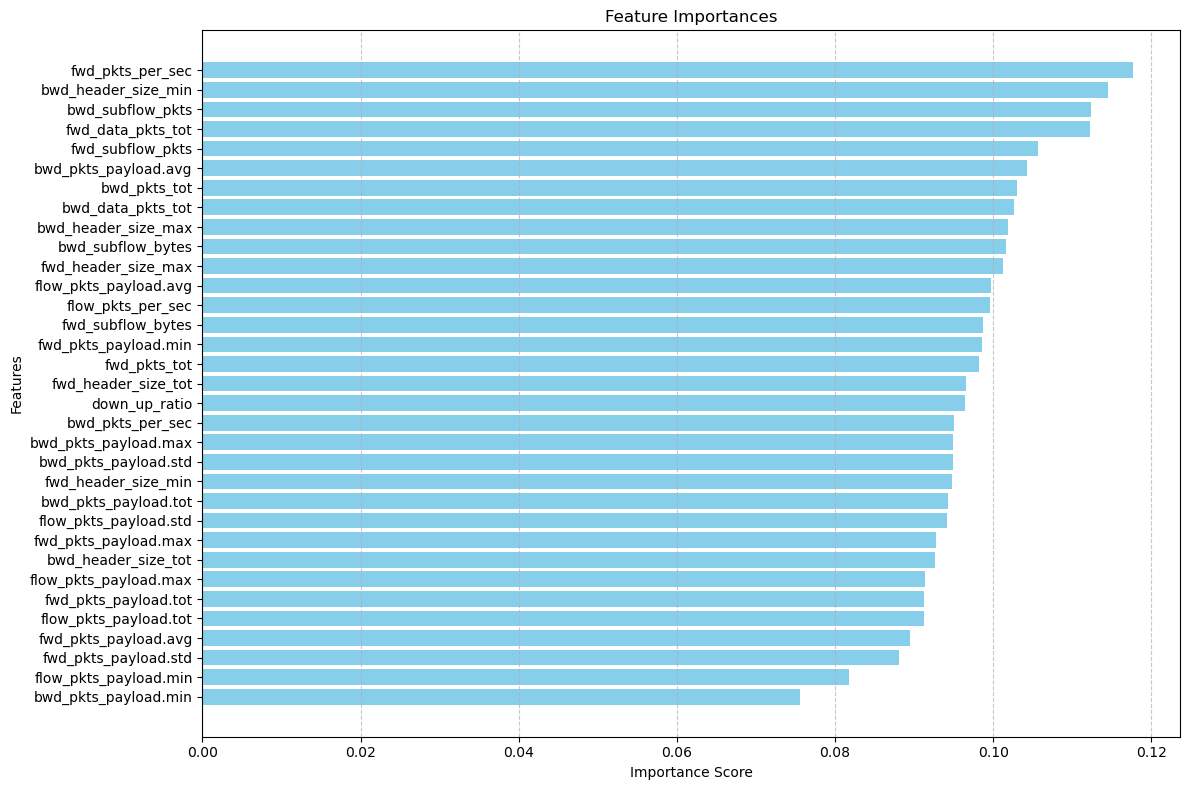

In [8]:
weights = model.get_weights()

input_layer_weights = weights[0]

importances = np.mean(np.abs(input_layer_weights), axis=1)

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot the feature importances
fig, ax = plt.subplots(figsize=(12, 8))

# Create horizontal bar plot
ax.barh(range(X_train.shape[1]), importances[indices], color="skyblue")

# Set y-axis labels
ax.set_yticks(range(X_train.shape[1]))
ax.set_yticklabels(feature_names[indices])

# Set title and labels
ax.set_title("Feature Importances")
ax.set_xlabel("Importance Score")
ax.set_ylabel("Features")

# Invert y-axis for better readability
ax.invert_yaxis()

# Add grid for better visualization
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Tight layout
plt.tight_layout()

# Show the plot
plt.show()

In [9]:
def calculate_feature_importance(model, feature_names):
    """
    Calculate feature importance using Gini index.

    Returns:
    - DataFrame: DataFrame containing feature names and their corresponding Gini importance.
    """
    # Create DataFrame to hold feature names
    dfp_importance = pd.DataFrame({'feat_names': feature_names})
    dfp_importance['feature'] = dfp_importance.index.astype(str)  

    # Create DataFrame to hold Gini importance
    dfp_importance_gini = pd.DataFrame({'importance_gini': importances})
    dfp_importance_gini['feature'] = dfp_importance_gini.index.astype(str)  

    # Calculate percentile rank of Gini importance
    dfp_importance_gini['importance_gini_pct'] = dfp_importance_gini['importance_gini'].rank(pct=True)

    # Merge DataFrames and sort by importance
    dfp_importance = pd.merge(dfp_importance, dfp_importance_gini, on='feature', how='left')
    dfp_importance = dfp_importance.sort_values(by=['importance_gini', 'feature'], ascending=[False, True]).reset_index(drop=True)
    
    return dfp_importance

%time importance_table = calculate_feature_importance(model, feature_names)
importance_table

CPU times: total: 0 ns
Wall time: 4.49 ms


,feat_names,feature,importance_gini,importance_gini_pct
0,fwd_pkts_per_sec,4,0.117732,1.000000
1,bwd_header_size_min,12,0.114455,0.969697
2,bwd_subflow_pkts,30,0.112366,0.939394
3,fwd_data_pkts_tot,2,0.112268,0.909091
4,fwd_subflow_pkts,29,0.105605,0.878788
5,bwd_pkts_payload.avg,22,0.104298,0.848485
6,bwd_pkts_tot,1,0.103020,0.818182
7,bwd_data_pkts_tot,3,0.102567,0.787879
8,bwd_header_size_max,13,0.101847,0.757576
9,bwd_subflow_bytes,32,0.101640,0.727273


## Shap

## InterpretML

In [10]:
import tensorflow as tf
tf.experimental.numpy.experimental_enable_numpy_behavior()

from interpret.blackbox import MorrisSensitivity
from sklearn.pipeline import Pipeline
from interpret import show

%time msa = MorrisSensitivity(model, X_test, feature_names=feature_names)

explanation = msa.explain_global()

# Extracting the Morris sensitivity results as a DataFrame
sensitivity_df = pd.DataFrame(explanation.data()["scores"], index=feature_names)
sorted_sensitivity_df = sensitivity_df.sort_values(by=sensitivity_df.columns[0], ascending=False)
print(sorted_sensitivity_df)

show(explanation, max_features=len(feature_names))

C:\Users\ivoafonsobispo\anaconda3\Lib\site-packages\SALib\util\__init__.py:302: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  unique_group_names = pd.unique(groups)


CPU times: total: 594 ms
Wall time: 331 ms
                              0
flow_pkts_payload.min  0.200158
fwd_pkts_per_sec       0.100166
fwd_pkts_payload.min   0.081270
fwd_subflow_pkts       0.079249
bwd_header_size_min    0.055242
fwd_header_size_max    0.043991
fwd_data_pkts_tot      0.041208
fwd_header_size_min    0.040160
fwd_header_size_tot    0.039466
flow_pkts_payload.avg  0.039324
flow_pkts_per_sec      0.037518
bwd_header_size_max    0.037338
bwd_subflow_pkts       0.036467
fwd_pkts_payload.tot   0.034819
bwd_pkts_tot           0.034799
down_up_ratio          0.034189
bwd_header_size_tot    0.033507
bwd_pkts_per_sec       0.032645
bwd_pkts_payload.avg   0.031693
flow_pkts_payload.max  0.031440
fwd_pkts_tot           0.031042
bwd_pkts_payload.max   0.030264
fwd_pkts_payload.avg   0.029965
flow_pkts_payload.tot  0.027443
fwd_subflow_bytes      0.027426
fwd_pkts_payload.std   0.025246
bwd_pkts_payload.std   0.024725
fwd_pkts_payload.max   0.024110
bwd_pkts_payload.tot   0.0193

<!-- http://127.0.0.1:7740/1573846079056/ -->

## LOFO

In [11]:
from lofo import LOFOImportance, Dataset
from sklearn.model_selection import KFold
import pandas as pd

def calculate_lofo_importance(df, target_column, feature_names, cv_splits=4, scoring="roc_auc"):
    """
    Calculate LOFO (Leave One Feature Out) importance using the specified validation scheme and scorer.
    """
    cv = KFold(n_splits=cv_splits, shuffle=False, random_state=None) # Don't shuffle to keep the time split validation

    # Define the dataset
    dataset = Dataset(df=df, target=target_column, features=feature_names)

    # Define the LOFOImportance object
    lofo_imp = LOFOImportance(dataset, cv=cv, scoring=scoring)

    # Get the mean and standard deviation of the importances in pandas format
    importance = lofo_imp.get_importance()
    
    return importance

%time importance = calculate_lofo_importance(df=df_test, target_column="is_attack", feature_names=feature_names)

importance

C:\Users\ivoafonsobispo\anaconda3\Lib\site-packages\lofo\lofo_importance.py:3: TqdmExperimentalWarning:

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)



[LightGBM] [Info] Number of positive: 3273, number of negative: 1461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2339
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.691381 -> initscore=0.806586
[LightGBM] [Info] Start training from score 0.806586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 3306, number of negative: 1428
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2358
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.698352 -> initscore=0.839464


  0%|          | 0/33 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 3273, number of negative: 1461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2331
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.691381 -> initscore=0.806586
[LightGBM] [Info] Start training from score 0.806586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 3306, number of negative: 1428
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2350
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.698352 -> initscore=0.839464


[LightGBM] [Info] Number of positive: 3306, number of negative: 1428
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2321
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.698352 -> initscore=0.839464
[LightGBM] [Info] Start training from score 0.839464
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 3301, number of negative: 1433
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2318
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 30
[Lig

[LightGBM] [Info] Number of positive: 3273, number of negative: 1461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2333
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.691381 -> initscore=0.806586
[LightGBM] [Info] Start training from score 0.806586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 3306, number of negative: 1428
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.698352 -> initscore=0.839464


[LightGBM] [Info] Number of positive: 3301, number of negative: 1433
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2251
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.697296 -> initscore=0.834455
[LightGBM] [Info] Start training from score 0.834455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 3296, number of negative: 1438
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2272
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.696240 -> initscore=0.829456


[LightGBM] [Info] Number of positive: 3273, number of negative: 1461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2307
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.691381 -> initscore=0.806586
[LightGBM] [Info] Start training from score 0.806586
[LightGBM] [Info] Number of positive: 3306, number of negative: 1428
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2327
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.698352 -> initscore=0.839464
[LightGBM] [Info] Start training from score 0.839464
[LightGBM] [Warning] N

[LightGBM] [Info] Number of positive: 3273, number of negative: 1461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2314
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.691381 -> initscore=0.806586
[LightGBM] [Info] Start training from score 0.806586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 3306, number of negative: 1428
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2331
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.698352 -> initscore=0.839464


[LightGBM] [Info] Number of positive: 3306, number of negative: 1428
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.698352 -> initscore=0.839464
[LightGBM] [Info] Start training from score 0.839464
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 3301, number of negative: 1433
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 30
[Lig

[LightGBM] [Info] Number of positive: 3301, number of negative: 1433
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2354
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.697296 -> initscore=0.834455
[LightGBM] [Info] Start training from score 0.834455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 3296, number of negative: 1438
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2373
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.696240 -> initscore=0.829456


,feature,importance_mean,importance_std,val_imp_0,val_imp_1,val_imp_2,val_imp_3
11,flow_pkts_per_sec,2.641860e-04,0.000391,-0.000324,0.000775,0.000270,0.000336
30,fwd_pkts_payload.tot,1.309598e-04,0.000155,0.000365,0.000138,-0.000070,0.000091
19,bwd_pkts_per_sec,1.094327e-04,0.000446,0.000005,-0.000539,0.000685,0.000287
21,bwd_subflow_pkts,1.037833e-04,0.000309,0.000200,0.000561,-0.000251,-0.000094
14,flow_pkts_payload.tot,1.041457e-05,0.000424,0.000035,0.000299,0.000395,-0.000687
20,fwd_pkts_payload.max,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
29,flow_pkts_payload.min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
24,bwd_pkts_payload.min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
12,flow_pkts_payload.max,-9.734804e-07,0.000002,-0.000004,0.000000,0.000000,0.000000
27,fwd_header_size_min,-7.504838e-06,0.000339,0.000429,0.000214,-0.000376,-0.000297
